<a href="https://colab.research.google.com/github/luguaita/luguaita.github.io/blob/master/ML_Supervised_learning_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised learning - decision trees**
## ICU patients survival at hospital
## Prediction: diamond prices
### **Taller 1**: Aprendizaje supervisado. Árboles de decisión.

----------

### **Antecedentes**

El objetivo del presente notebook es el de desarrollar dos desafíos relacionados con árboles de decisión. El primero se basa en la predicción de supervivencia de pacientes de la Unidad de Cuidados Intensivos (UCI), mientras que el segundo contempla la predicción de precios de diamantes.

### **Desafío 1: Supervivencia de pacientes en la UCI**

Crear un árbol de decisión, que nos permita intentar predecir la supervivencia del paciente de la Unidad de Cuidados Intensivos (UCI). El set de datos contiene información del paciente, signos vitales, enfermedades crónicas, comorbilidades, etc.

Para ello, se utilizará la base de datos "Dataset.csv".

####**1. Librerías**

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from pandas.plotting import scatter_matrix
from numpy.matrixlib.defmatrix import matrix

# Evaluación
# ------------------------------------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

# Valores perdidos o nulos
# ------------------------------------------------------------------------------
import missingno as msgn

# Configuración de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

####**2. Carga de datos**

In [ ]:
#Indicando la carpeta de Google Drive donde se almacenan los archivos
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.10/threading.py:957: ResourceWarning: unclosed file <_io.FileIO name=44 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.10/threading.py:957: ResourceWarning: unclosed file <_io.FileIO name=45 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f

Mounted at /content/drive


In [ ]:
#Identificando la ruta y nombre del archivo
df = pd.read_csv('/content/drive/MyDrive/Dataset.csv')

####**3. Preprocesamiento y limpieza de datos**

In [ ]:
#Identificando la cantidad de datos que contiene el dataset
df.shape

(91713, 186)

**Observación**: la base contiene 91713 filas o registros y 186 columnas o variables.

In [ ]:
#Identificando las columnas del dataset
df.head(4)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


**Observación**: Si bien el dataset cuenta con 186 columnas o variables, solo es posible observar 20 de ellas con la función .head(). Esto debido a la cantidad de variables sobrepasa el espacio visible con el que se cuenta para observar la tabla de datos.

In [ ]:
#Evidenciando el tipo de datos con los que cuenta el dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


**Observación**: existen variables categóricas (*object(8)*) en el dataset. Se deberá determinar si es necesario llevar a cabo una transformación de estas variables mediante *dummy* o *one-hot-encoder* puesto que el modelo solo admitirá variables numéricas.

In [ ]:
#Verificando la cantidad de registros por cada variable
df.count()

encounter_id                   91713
patient_id                     91713
hospital_id                    91713
hospital_death                 91713
age                            87485
                               ...  
leukemia                       90998
lymphoma                       90998
solid_tumor_with_metastasis    90998
apache_3j_bodysystem           90051
apache_2_bodysystem            90051
Length: 186, dtype: int64

**Observación**: se observan variables con menos de 91713 registros. Esto puede indicar que existen registros con datos incompletos o nulos, por lo que se deberá determinar la factibilidad de imputar datos o despejar las columnas que sean de tipo identificador.

In [ ]:
#Visualizando la cantidad de datos faltantes
df.isnull().sum().sort_values(ascending = False)

h1_bilirubin_min         84619
h1_bilirubin_max         84619
h1_lactate_max           84369
h1_lactate_min           84369
h1_albumin_max           83824
                         ...  
icu_type                     0
pre_icu_los_days             0
readmission_status           0
apache_post_operative        0
encounter_id                 0
Length: 186, dtype: int64

**Observación**: existen variables (h1_bilirubin_min, h1_bilirubin_max) con 84619 datos faltantes. Por otra parte, h1_lactate_max, h1_lactate_min presentan 84369 datos faltantes, y h1_albumin_max tiene 83824 datos nulos. A su vez, según lo arrojado mediante la función isnull(), se evidencia que las variables como icu_type, pre_icu_los_days, readmission_status, apache_pos_operative y encounter_id tienen sus datos completos, es decir, no registran datos faltantes o nulos.

Adicionalmente, se observan columnas con el sufijo "**id**". Esto quiere decir que se trata de **variables de tipo identificador**, por lo que podría prescindirse de ellas al únicamente contener información de identificación.

In [ ]:
#Creando un nuevo dataframe (df2) en donde se eliminan columnas de tipo identificador
df2 = df.drop(columns = ['encounter_id','patient_id','hospital_id'])

In [ ]:
#Buscando todas las columnas del dataset con el identificador "_id"
col_sufijo_id = [col for col in df2.columns if '_id' in col]

In [ ]:
#Eliminando todas las columnas restantes que sean de tipo identificador
df3 = df2.drop(col_sufijo_id, axis=1)

In [ ]:
#Observando cambios en las variables mostradas
df3.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity',
       'gender', 'height', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=182)

**Observación**: se observa que la cantidad de columnas se redujo de 186 a 182.

In [ ]:
#Identificando la cantidad de datos que contiene el dataset
#para verificar la reducción en la cantidad de columnas
df3.shape

(91713, 182)

#####**3.1. Valores nulos o perdidos**

In [ ]:
#Creando una copia (df4) del dataframe
df4 = df3

In [ ]:
#Se determina el porcentaje de filas con datos perdidos
((df4.shape[0] - df4.dropna().shape[0]) / df4.shape[0] )*100

99.97274105088701

**Observación**: Se observa que el 99.97% de las filas poseen datos faltantes. Por lo tanto, se deberá seleccionar la mejor forma de imputar datos y reducir la cantidad de elementos faltantes o nulos.

In [ ]:
#Creando una función para identificar datos missing o perdidos, por su nombre en inglés
def missing(df4,var):

    """Descripción de la función "missing":
    Con 'missing', se calculan los valores perdidos de variables de un
    data frame.

    Parámetros de esta función:
    df: data frame (ingresar en la versión de copia que corresponda)
    var: variable del data frame

    Return (retorno de la función):
    El resultado arroja un string con el porcentaje de valores perdidos
    para la variable var
   """

    n_perdidos = len(df4[df4[var].isna()][var])
    n_total = len(df4[var])
    porcentaje = (n_perdidos / n_total)*100

    return n_perdidos, porcentaje

In [ ]:
#Generando un dataframe con los datos de los valores perdidos por columnas
_col = []
_nans = []
_porcentaje = []

for colum in df4.columns:
    nan, porcentaje = missing(df4, colum)
    _col.append(colum)
    _nans.append(nan)
    _porcentaje.append(porcentaje)

In [ ]:
#Con df_nans se concatenan los tres dataframes de pandas
#Con pd.concat se concatenan columnas por nombre
df4_nans = pd.concat([pd.DataFrame(_col, columns=['columna']),
                        pd.DataFrame(_nans, columns=['perdidos']),
                           pd.DataFrame(_porcentaje, columns=['%'])], axis = 1)

In [ ]:
#Identificando las columnas con mayor cantidad de valores perdidos o nan al 85%
top_nans = df4_nans[df4_nans['%'] > 85].sort_values('%', ascending=False)
top_nans

,columna,perdidos,%
126,h1_bilirubin_max,84619,92.265001
127,h1_bilirubin_min,84619,92.265001
144,h1_lactate_max,84369,91.992411
145,h1_lactate_min,84369,91.992411
124,h1_albumin_max,83824,91.398166
125,h1_albumin_min,83824,91.398166
168,h1_pao2fio2ratio_max,80195,87.441257
169,h1_pao2fio2ratio_min,80195,87.441257


In [ ]:
#Obteniendo la cantidad de columnas a eliminar
top_nans.shape[0]

8

In [ ]:
#Eliminando las columnas con más del 85% de sus valores perdidos
df5 = df4.drop(columns = list(top_nans['columna']))

In [ ]:
#Comprobando la eliminación de las columnas
df5.shape

(91713, 174)

**Observación**: Se redujo la cantidad de columnas del dataset puesto que ahora se cuenta con 174 de las 186 variables iniciales.

#####**3.2 Imputación de valores nulos o perdidos**

**Variables numéricas**: Se imputarán los valores perdidos o faltantes a través de la media.

In [ ]:
#Creando la variable "col_numericas"
col_numericas = df5.select_dtypes(include=['float64', 'int64']).columns.to_list()

In [ ]:
#Imputando con la media los datos faltantes de las columnas numéricas
df5[col_numericas] = df5[col_numericas].apply(lambda x: x.fillna(x.mean()),axis=0)

**Variables categóricas**: Por la naturaleza de los datos, no se imputarán a través de la moda puesto que los valores corresponden al área de la salud. En este caso, se reemplazarán los datos faltantes mediante las iniciales "SD" correspondientes a "Sin Dato".

In [ ]:
#Creando la variable "col_categoricas"
col_categoricas = df5.select_dtypes(include=['object']).columns.to_list()

In [ ]:
#Imputando con "SD" los valores faltantes de las variables categóricas
df5[col_categoricas] = df5[col_categoricas].fillna('SD')

In [ ]:
#Identificando la cantidad de variables o atributos
df5.shape[1]

174

**Observación**: Contamos con 174 variables o atributos.

#####**3.3 Identificación de outliers**

Si bien es una práctica habitual realizar un procesamiento a los valores fuera de rango o outliers, estos se descartarán en este desafío por la naturaleza de los datos. Se anticipa que, al tratarse de pacientes en una sala de cuidados intensivos, pueden existir valores fuera de rango de manera frecuente.
Se sugiere contactar a personal del área de la salud cuando el análisis no sea realizado con fines educativos.

####**4. Análisis descriptivo**

In [ ]:
#Obteniendo las estadísticas descriptivas de las columnas numéricas del dataframe
df5.describe()

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.0,91713.000000,91713.000000,91713.000000,...,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000
mean,0.086302,62.309516,29.185818,0.183736,169.641588,0.835766,0.0,84.028340,2.902968,185.401739,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,0.280811,16.383883,8.118970,0.387271,10.716578,2.487756,0.0,24.637809,0.435041,85.267612,...,0.236599,0.207712,0.029151,0.123799,0.416079,0.112786,0.159004,0.083436,0.063897,0.141614
min,0.000000,16.000000,14.844926,0.000000,137.200000,-24.947222,0.0,38.600000,1.200000,101.000000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,23.787760,0.000000,162.560000,0.035417,0.0,67.300000,2.902968,113.000000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,64.000000,28.007812,0.000000,170.000000,0.138889,0.0,81.400000,2.902968,123.000000,...,0.060000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,75.000000,32.653061,0.000000,177.800000,0.409028,0.0,96.300000,2.902968,301.000000,...,0.120000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,89.000000,67.814990,1.000000,195.590000,159.090972,0.0,186.000000,4.600000,308.000000,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Observación**: Al contar con más de 166 columnas con datos numéricos, se seleccionará la variable principal del dataset para el caso en estudio, la cual corresponde a "hospital_death" y nos podrá ayudar a esclarecer la supervivencia de los pacientes en el área de UCI.

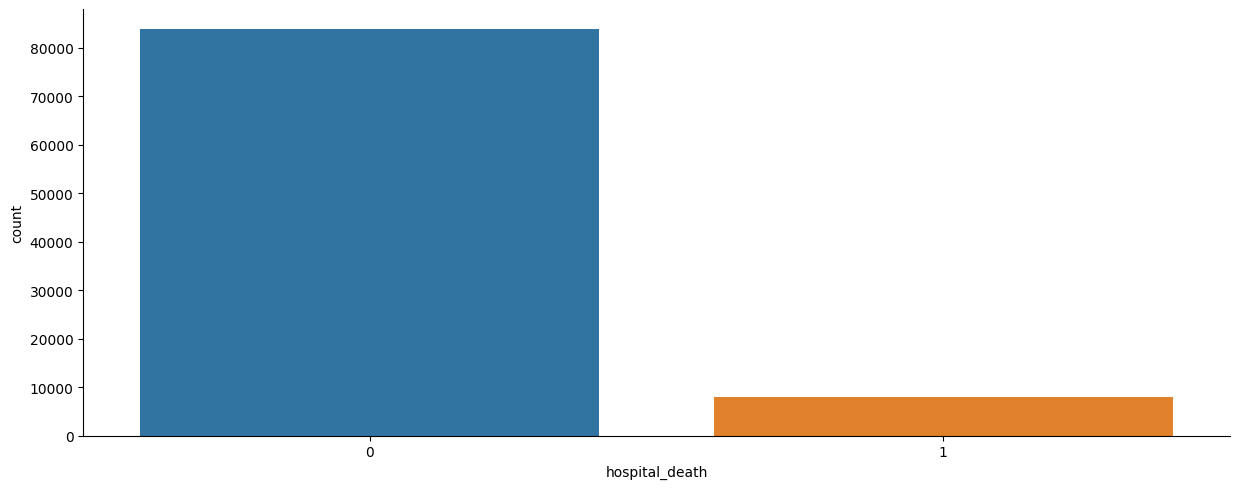

In [ ]:
#Utilizando catplot de seaborn para mostrar la frecuencia (eje y)
#para cada categoría de la variable "hospital_death" (eje x) en el DataFrame "df5"
#Es decir, indicando si el paciente "sobrevive (0)" o "no sobrevive (1)"

sns.catplot(x='hospital_death', data=df5 , kind='count',aspect=2.5 )
plt.show()

**Observación**: Los datos se encuentran desbalanceados. Existe una mayor proporción de "0" (pacientes que sobreviven) que de "1" (pacientes que no sobreviven) en el dataset. De allí que, en la creación del modelo, se deba seleccionar el **modo (class_weight) = balanced**.

####**5. Ajuste del modelo**

Con el fin de generar el set de entrenamiento (train) y testeo (test), se crean _X e _Y para la variable "hospital_death" escogida en el análisis por ser indicativa de la supervivencia de los pacientes de la UCI.

In [ ]:
#Creando _X para eliminar la variable "hospital_death" de la matriz de variables o atributos
_X = df5.drop(columns = ['hospital_death'])
#Creando _Y para conservar la variable "hospital_death"
_y = df5['hospital_death']

In [ ]:
# Dividiendo los datos en train y test y creando la semilla (3570)
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(_X, _y, random_state = 3570)

# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.fit_transform(X_test)

Asegurándonos de que el modelo tiene solo datos numéricos:

In [ ]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(col_categoricas)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68784 entries, 0 to 68783
Columns: 231 entries, age to apache_2_bodysystem_Undefined diagnoses
dtypes: float64(231)
memory usage: 121.2 MB


- Gracias al uso de one-hot hemos conseguido que la matriz de atributos contenga valores numéricos.


- **En la creación del modelo se especificará el modo "balanced", el cual utiliza los valores del atributo objetivo para ajustar automáticamente los pesos inversamente proporcionales a las frecuencias de clase. Con esto damos lógica al desbalance que existe entre clases y le damos consistencia a la interpretación de las predicciones.**


- **Por otro lado, el desafío implica poder predecir de forma correcta tanto la supervivencia, como también la no supervivencia, por tanto, ambas clases son importantes de verificar en las métricas de desempeño. Es importante predecir con alto accuracy que el paciente tiene signos de supervivencia (por tanto, no tomar medidas), y también importante predecir con alto accuracy que el paciente tiene signos de no supervivencia (por tanto, tomar medidas)**.


- Definiremos un modelo inicial discrecionalmente con profundidad 4 para ver su comportamiento.

In [ ]:
# Creación del modelo inicial
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth = 4,
            criterion = 'gini',
            random_state = 3575,
            class_weight = 'balanced'
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=3575)

**Observación**: Se ha creado un modelo de entrenamiento mediante un árbol de clasificación (DecisionTreeClassifier), balanceado (class_weight='balanced'), con una profundidad máxima inicial asumida en 4 (max_depth=4), y una semilla (random_state=3575).

Creando la estructura del árbol, con nodos terminales.

Profundidad del árbol: 4
Número de nodos terminales: 16


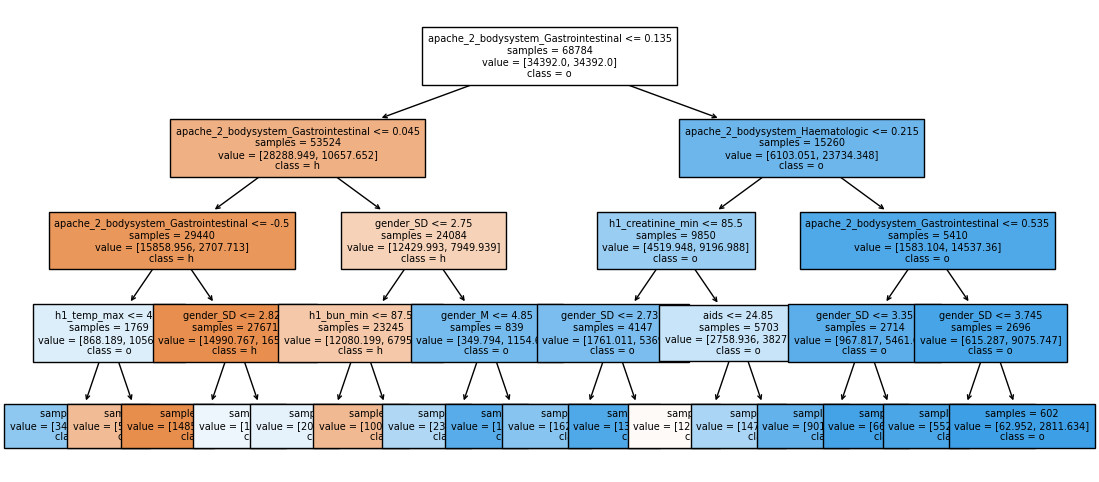

In [ ]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'hospital_death',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

**Observación**: Se obtiene un primer árbol como resultado del **modelo inicial**, sin poda con 16 nodos terminales y una profundidad de 4.

####**6. Predicción y evaluación del modelo inicial**

Evaluando la capacidad predictiva del modelo inicial.

In [ ]:
# Predicciones del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)

Se utilizará el "**accuracy_score**" debido a que el modelo se basa en un árbol de decisión clasificador (por tener variables categóricas "sobrevive" y "no sobrevive").

In [ ]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")
print("El accuracy de test Inicial es :{r:2.2f}%".format(r=accuracy*100))  # 2 es el espacio , 2f cuántos decimales en flotante

El accuracy de test es: 77.88826377077064 %
El accuracy de test Inicial es :77.89%


**Observación**: El accuracy global es de 77.89%. Es decir, aproximadamente, de cada 100 predicciones, el modelo acertará 77 y fallará en 23. Sin embargo, se revisará el accuracy de ambas clases ya que es importante que sea alto para ambas clases.

In [ ]:
print(classification_report(predicciones, y_test))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87     16859
           1       0.76      0.24      0.37      6070

    accuracy                           0.78     22929
   macro avg       0.77      0.61      0.62     22929
weighted avg       0.77      0.78      0.73     22929



**Observación**: Si bien tenemos un accuracy global de 78%, vemos que el recall (sensibilidad) es muy bajo (24%), es decir, de todos los individuos que no sobreviven (clase 1), el modelo solo es capaz de identificar correctamente al 24%. Por esto, es que los modelos no deben medirse solo con solo una métrica.

####**7. Podado del árbol (pruning)**

Aunque inicialmente se ha empleado un valor de **max_depth=4**, este no tiene por qué ser el mejor valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

In [ ]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
# Limitando la profundidad del árbol mediante 'max_depth'
param_grid = {'ccp_alpha':np.linspace(0, 5, 10),
              'max_depth': list(range(2,6))}

**Observación**: Se ha creado el diccionario **param_grid** para especificar los valores de los parámetros del árbol y evitar sobreajustes o subajustes. Los parámetros son **ccp_alpha**: para controlar la complejidad del árbol, con 10 valores que van de 0 a 5 separados uniformemente, y **max_depth**: para controlar la profundidad máxima del árbol. Se especifican valores en el rango entre 2 y 6.

In [ ]:
# Técnicas de optimización por hiperparámetros
#-------------------------------------------------------------------------------
# Búsqueda por validación cruzada:
# Se realizará mediante Grid Search para buscar todas las combinaciones posibles
grid = GridSearchCV(
        # El árbol se hace crecer al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            #max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 3575,
                            class_weight = 'balanced' # <-Porque los datos estaban desbalanceados
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 3,#Cross-validation: parámetro que divide el conjunto en partes iguales para testear y entrenar al modelo
        refit      = True, #Para reentrenar al modelo una vez obtenido el ccp_alpha
        return_train_score = True
      )

In [ ]:
grid.fit(X_train_prep, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=3575),
             param_grid={'ccp_alpha': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
                         'max_depth': [2, 3, 4, 5]},
             return_train_score=True, scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


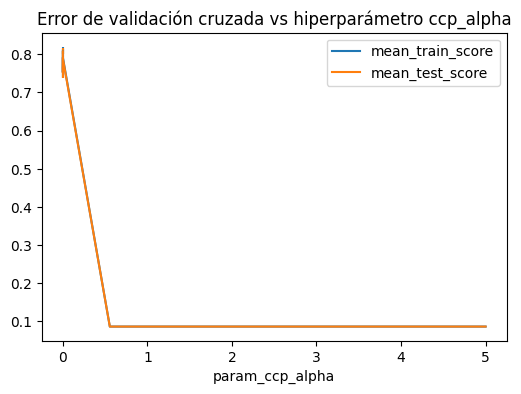

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validación cruzada vs hiperparámetro ccp_alpha");

####**8. Predicción y evaluación del modelo final**

In [ ]:
# Mejor valor ccp_alpha encontrado y profundidad máxima max_depth
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0, 'max_depth': 2}

**Observación**: Hemos identificado el valor óptimo de `ccp_alpha` en 0, con una profundidad igual a 2.

Una vez identificado el valor óptimo de `ccp_alpha`, se reentrena el árbol indicando este valor en sus argumentos. Si en el `GridSearchCV()` se indica `refit=True`, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_.`

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol final: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol final: 2
Número de nodos terminales: 4


**Observación**: El árbol final tiene una profundidad igual a 2, con 4 nodos terminales. Esto pudiese traducirse en que no se encuentra sobreajustado y puede que no se aprenda los datos, lo que podría conllevar a un modelo eficiente.

In [ ]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")
print("El accuracy de test final es :{r:2.1f}%".format(r=accuracy*100))

El accuracy de test es: 81.34676610406036 %
El accuracy de test final es :81.3%


In [ ]:
print(classification_report(predicciones, y_test))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     17970
           1       0.67      0.27      0.38      4959

    accuracy                           0.81     22929
   macro avg       0.75      0.62      0.64     22929
weighted avg       0.79      0.81      0.78     22929



**Observación**: Con el `modelo inicial` se obtuvo un **accuracy aproximado de 77%** y una **sensibilidad** a los casos de **no sobrevivientes de 24%**.

Por otra parte, para el `modelo final`, se obtuvo un **accuracy de 81.3%** y una **sensibilidad de 27%** para la variable de no supervivencia.

Es decir, se mejoró alrededor de 4% de accuracy y 3% de sensibilidad a la variable de no supervivencia. Con esto, se logra tener un porcentaje aceptable de accuracy. Sin embargo, el porcentaje para la variable de no supervivencia se mantiene bajo, por lo que es recomendable realizar análisis adicionales.

####**9. Importancia de predictores**

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el índice Gini, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna división, no se ha incluido en el modelo y por lo tanto su importancia es 0.

**Generando una tabla con los 10 atributos más importantes para el modelo**.

In [ ]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels.tolist(),
                             'importancia': modelo_final.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)[0:10]

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
221,apache_2_bodysystem_Gastrointestinal,0.92889
222,apache_2_bodysystem_Haematologic,0.07111
0,age,0.00000
158,cirrhosis,0.00000
146,d1_arterial_po2_min,0.00000
147,d1_pao2fio2ratio_max,0.00000
148,d1_pao2fio2ratio_min,0.00000
149,h1_arterial_pco2_max,0.00000
150,h1_arterial_pco2_min,0.00000
151,h1_arterial_ph_max,0.00000


**Observación**: De la tabla, se obtiene que la variable o atributo de mayor importancia en el modelo es aquella que indica el grupo de diagnóstico de ingreso al centro médico con la etiqueta "apache_2_bodysystem_Gastroinstestinal". Mientras que, la siguiente, contiene la etiqueta "apache_2_bodysystem_Haematologic".

#####**9.1 Predicción de probabilidades**

La mayoría de implementaciones de los modelos basados en árboles, entre ellas la de **scikit-learn**, permiten predicir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

In [ ]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[0.69144311, 0.30855689],
       [0.90822206, 0.09177794],
       [0.90822206, 0.09177794],
       [0.1762227 , 0.8237773 ],
       [0.90822206, 0.09177794]])

El resultado de `.predict_proba()` es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada clase en el nodo terminal al que ha llegado la observación predicha.

Por defecto, `.predict()` asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [ ]:
# Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.691443,0.308557,0
1,0.908222,0.091778,0
2,0.908222,0.091778,0


**Observación**: Para la supervivencia, se obtiene una probabilidad de 69%.

####**10. Conclusiones: Desafío 1**

Luego del preprocesamiento y limpieza de datos fue posible crear el modelo inicial de un árbol de decisión - clasificación para intentar predecir la supervivencia de pacientes de la Unidad de Cuidados Intensivos (UCI).

Con esto, se obtuvo un porcentaje aproximado de **69% de supervivencia**, siendo el 31% restante destinado a la no supervivencia.

Sin embargo, mediante consultas en la sala de clase, se identificó una función que pudo haberse empleado en el análisis con el final de optimizar aún más este set de datos.

Con ello, pudiese mejorar no solo el **accuracy** (el cual nos dio un **máximo de 81.3%** luego de la poda), sino también la **sensibilidad** (la cual llegó a un **máximo de 27%** luego de la poda).

En este sentido, para el punto "**5. Ajuste del modelo**", luego de separar la variable "hospital_death" en "_X" e "_Y", podrían aplicarse los siguientes códigos en el mismo orden:


    #Usar SelectKBest para seleccionar las mejores variables
    selector = SelectKBest(f_classif, k=6) #El valor de "k" se obtiene luego de iterar.
    selector.fit(X, y)

    #Para obtener los índices de las columnas
    selected_indices = selector.get_support(indices=True)

    #Para crear un nuevo dataframe con las columnas seleccionadas
    selected_columns = X.columns[selected_indices]
    X_new = X[selected_columns]

    #Para identificar los nombres de las columnas seleccionadas.
    #Estas corresponden a las variables más importantes que explican "hospital_death" en el modelo.
    print(selected_columns)

### **Desafío 2: Costo de diamantes**

Crear un árbol de decisión, que nos permita intentar predecir el precio de los “diamantes”. El set de datos contiene información que contiene los precios y otros atributos de casi 54.000 diamantes. Las variables son las siguientes:

Variable | Descripción | Clasificación
--- | --- | ---
precio | precio en dólares estadounidenses USD (326 – 18,823) | Numérica
quilate | peso del diamante (0,2–5,01) | Numérica
corte | calidad del corte (Regular, Buena, Muy buena, Premium, Ideal) | Categórica
color | color diamante, de J (peor) a D (mejor) | Categórica
claridad | una medida de la claridad del diamante (I1 (peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor)) | Categórica
x | longitud en mm (0–10,74) | Numérica
y | anchura en mm (0–58,9) | Numérica
z | profundidad en mm (0–31,8) | Numérica
profundidad | porcentaje de profundidad total = z / media (x, y) = 2 * z / (x + y) (43–79) | Numérica

####**1. Librerías**

Para efectos de comprensión lectora, se han unido todas las librerías al inicio del documento.

####**2. Carga de datos**

In [ ]:
#Indicamos la carpeta de Google Drive donde se almacenan los archivos
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

/usr/lib/python3.10/threading.py:957: ResourceWarning: unclosed file <_io.FileIO name=39 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.10/threading.py:957: ResourceWarning: unclosed file <_io.FileIO name=40 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f53dd08ae60>
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
#Entregamos la ruta, nombre de archivo, separador de campos y página de caracteres.
dfd = pd.read_excel('/content/drive/MyDrive/diamantes.xlsx')

####**3. Preprocesamiento y limpieza de datos**

Se analizan los casos de datos faltantes y no se encuentran eventos, el data set está completo. Solo se debe transformar a números las columnas categóricas.

In [ ]:
#Identificando la cantidad de datos que contiene el dataset
dfd.shape

(53940, 10)

**Observación**: la base contiene 53940 filas o registros y 10 columnas o variables.

In [ ]:
#Identificando las columnas del dataset
dfd.head(4)

,precio,quilate,corte,color,claridad,profundidad,tabla,x,y,z
0,326,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,0.23,Bueno,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63


**Observación**: Se observan las primeras 4 filas y las 10 variables o columnas del dataset.

In [ ]:
#Evidenciando el tipo de datos con los que cuenta el dataset
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   precio       53940 non-null  int64  
 1   quilate      53940 non-null  float64
 2   corte        53940 non-null  object 
 3   color        53940 non-null  object 
 4   claridad     53940 non-null  object 
 5   profundidad  53940 non-null  float64
 6   tabla        53940 non-null  float64
 7   x            53940 non-null  float64
 8   y            53940 non-null  float64
 9   z            53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


**Observación**: existen variables categóricas (*object(3)*) en el dataset. Estas corresponden a: "corte", "color", y "claridad". Se deberá determinar si es necesario llevar a cabo una transformación de estas variables mediante *dummy* o *one-hot-encoder* puesto que el modelo solo admitirá variables numéricas.

#####**3.1. Valores nulos o perdidos**

In [ ]:
#Verificando la cantidad de registros por cada variable
dfd.count()

precio         53940
quilate        53940
corte          53940
color          53940
claridad       53940
profundidad    53940
tabla          53940
x              53940
y              53940
z              53940
dtype: int64

In [ ]:
#Otra forma de identificar cuántos datos nulos existen
print("Cantidad de datos nulos= ",dfd.shape[0] - dfd.dropna().shape[0] )

Cantidad de datos nulos=  0


**Observación**: se observa que todas las variables contienen 53940 datos, los cuales corresponden con los del dataset. Esto indica que no existen datos faltantes o perdidos (NA). Por lo tanto, no se hace necesaria la imputación de datos.

#####**3.2 Imputación de variables categóricas**

In [ ]:
#Creando 3 DataFrames con el sufijo "cat" para las variables categóricas
claridad_cat     = dfd[["claridad"]]
color_cat        = dfd[["color"]]
corte_cat        = dfd[["corte"]]

ordinal_encoder  = OrdinalEncoder()

#Transformando las columnas con variables categóricas en numéricas
#mediante ".fit_transform"
dfd["claridad_encoder"] = ordinal_encoder.fit_transform(claridad_cat)
dfd["color_encoder"]    = ordinal_encoder.fit_transform(color_cat)
dfd["corte_encoder"]    = ordinal_encoder.fit_transform(corte_cat)

In [ ]:
#Verificando la creación de las 3 columnas con el sufijo "encoder"
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            53940 non-null  int64  
 1   quilate           53940 non-null  float64
 2   corte             53940 non-null  object 
 3   color             53940 non-null  object 
 4   claridad          53940 non-null  object 
 5   profundidad       53940 non-null  float64
 6   tabla             53940 non-null  float64
 7   x                 53940 non-null  float64
 8   y                 53940 non-null  float64
 9   z                 53940 non-null  float64
 10  claridad_encoder  53940 non-null  float64
 11  color_encoder     53940 non-null  float64
 12  corte_encoder     53940 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 5.4+ MB


**Observación**: se logra la creación de las columnas "claridad_encoder", "color_encoder" y "corte_encoder", las cuales contienen datos numéricos.
Nota: aún se encuentran en el dataset estas variables en su versión categórica.

In [ ]:
#Convirtiendo la columna "precio" a float
dfd['precio'] = dfd['precio'].astype(float)
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            53940 non-null  float64
 1   quilate           53940 non-null  float64
 2   corte             53940 non-null  object 
 3   color             53940 non-null  object 
 4   claridad          53940 non-null  object 
 5   profundidad       53940 non-null  float64
 6   tabla             53940 non-null  float64
 7   x                 53940 non-null  float64
 8   y                 53940 non-null  float64
 9   z                 53940 non-null  float64
 10  claridad_encoder  53940 non-null  float64
 11  color_encoder     53940 non-null  float64
 12  corte_encoder     53940 non-null  float64
dtypes: float64(10), object(3)
memory usage: 5.4+ MB


**Eliminamos las columnas categóricas y creamos un nuevo dataframe (dfd2)**

Nota: Si bien es poco frecuente encontrar dataframes abreviados como "dfd", en este caso, la letra **d** adicional al final indica **diamante**. Esto se realiza con el fin de diferenciar el set de datos del Desafío 1 y Desafío 2.

In [ ]:
#Eliminando las variables categóricas
#Evidenciando el cambio mediante la función ".head()"
dfd2 = dfd.drop(columns = ['corte','color','claridad']) #Generando "dfd2" para no modificar "dfd".

dfd2.head(5)

,precio,quilate,profundidad,tabla,x,y,z,claridad_encoder,color_encoder,corte_encoder
0,326.0,0.23,61.5,55.0,3.95,3.98,2.43,3.0,1.0,1.0
1,326.0,0.21,59.8,61.0,3.89,3.84,2.31,2.0,1.0,3.0
2,327.0,0.23,56.9,65.0,4.05,4.07,2.31,4.0,1.0,0.0
3,334.0,0.29,62.4,58.0,4.20,4.23,2.63,5.0,5.0,3.0
4,335.0,0.31,63.3,58.0,4.34,4.35,2.75,3.0,6.0,0.0


#####**3.3 Identificación de outliers**

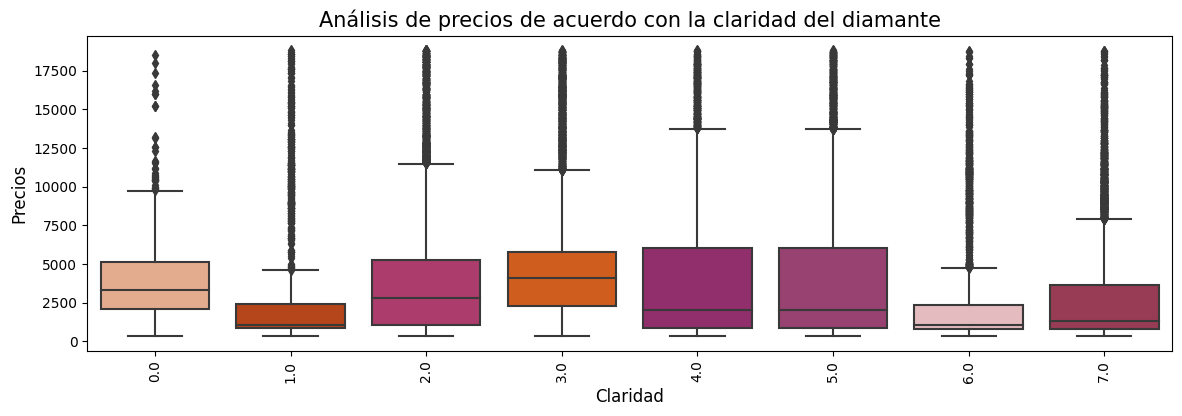

In [ ]:
#Mediante la librería matplotlib se graficarán los datos con
#box-and-whisker-plots o gráficos de caja
paleta_colores = sns.color_palette(["#F3A87F", "#CF3A00", "#BE2968", "#EC5601",
                                "#A11D70", "#A53472", "#EBB4BA", "#A72D4E"])
plt.figure(figsize = (14,9))

plt.subplot(211)
ax = sns.boxplot(x='claridad_encoder', y='precio', data=dfd2, palette= paleta_colores)
ax.set_title("Análisis de precios de acuerdo con la claridad del diamante", fontsize=15)
ax.set_xlabel("Claridad", fontsize=12)
ax.set_ylabel("Precios", fontsize=12)
plt.tick_params(axis='x', rotation=90)

plt.show()

**Observación**: del diagrama, se evidencia que todos los tipos de claridad (variable que ha sido transformada a numérica) presentan outliers. Por esta razón, se podría preferir la medida de rendimiento MAE (Mean Absolute Error) o EAM (Error Absoluto Medio) en lugar de MSE (Mean Squared Error) o RECM (Raíz del Error Cuadrático Medio).

####**4. Análisis descriptivo**

<ipython-input-115-f36d448c9617>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_bins = np.int((np.max(dfd2) -  np.min(dfd2)) / bin_width)  + 1




N° de bins adecuados para el histograma:  80


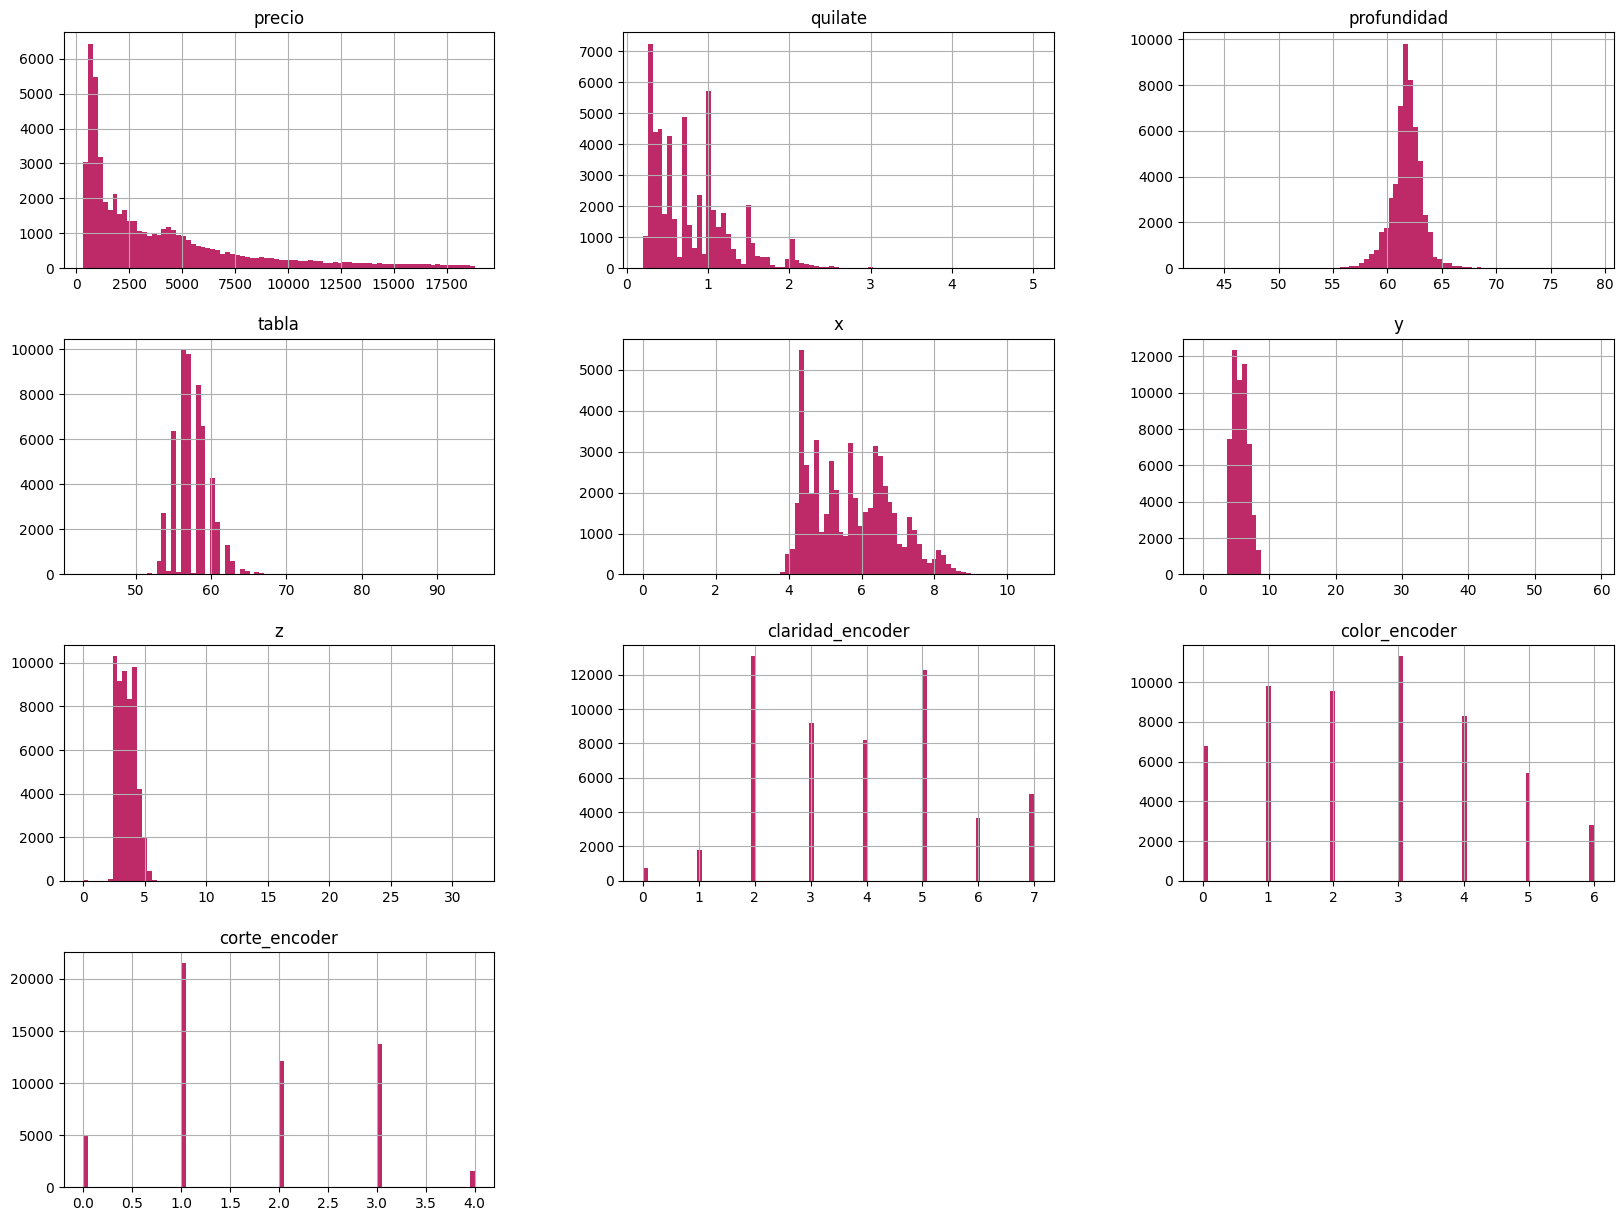

In [ ]:
#Creando la función "freedman_diaconis" para contrastar las variables con el
#precio de los diamantes

def freedman_diaconis(dfd2):

    """Descripción de la función "freedman_diaconis":
     Con este método de Freedman-Diaconis, se determina el número de bins
     adecuados utilizando el IQR y el número de datos para calcular el ancho.

    Parámetros de esta función:
    df: data frame (ingresar en la versión de copia que corresponda)

    Return (retorno de la función):
    El resultado arroja un string con el número de bins adecuados.
    """
    num_data = len(dfd2)
    irq = np.percentile(dfd2, 75) - np.percentile(dfd2, 25)
    bin_width = 2 * irq / np.power(num_data, 1/3)
    num_bins = np.int((np.max(dfd2) -  np.min(dfd2)) / bin_width)  + 1
    return num_bins

n_bins = freedman_diaconis(dfd2.precio)
print("\n\nN° de bins adecuados para el histograma: ",n_bins)
dfd2.hist(bins=n_bins, figsize=(20,15), color = "#BE2968")
plt.show()

array([[<Axes: xlabel='precio', ylabel='precio'>,
        <Axes: xlabel='quilate', ylabel='precio'>,
        <Axes: xlabel='profundidad', ylabel='precio'>,
        <Axes: xlabel='tabla', ylabel='precio'>,
        <Axes: xlabel='x', ylabel='precio'>,
        <Axes: xlabel='y', ylabel='precio'>,
        <Axes: xlabel='z', ylabel='precio'>],
       [<Axes: xlabel='precio', ylabel='quilate'>,
        <Axes: xlabel='quilate', ylabel='quilate'>,
        <Axes: xlabel='profundidad', ylabel='quilate'>,
        <Axes: xlabel='tabla', ylabel='quilate'>,
        <Axes: xlabel='x', ylabel='quilate'>,
        <Axes: xlabel='y', ylabel='quilate'>,
        <Axes: xlabel='z', ylabel='quilate'>],
       [<Axes: xlabel='precio', ylabel='profundidad'>,
        <Axes: xlabel='quilate', ylabel='profundidad'>,
        <Axes: xlabel='profundidad', ylabel='profundidad'>,
        <Axes: xlabel='tabla', ylabel='profundidad'>,
        <Axes: xlabel='x', ylabel='profundidad'>,
        <Axes: xlabel='y', ylabel='p

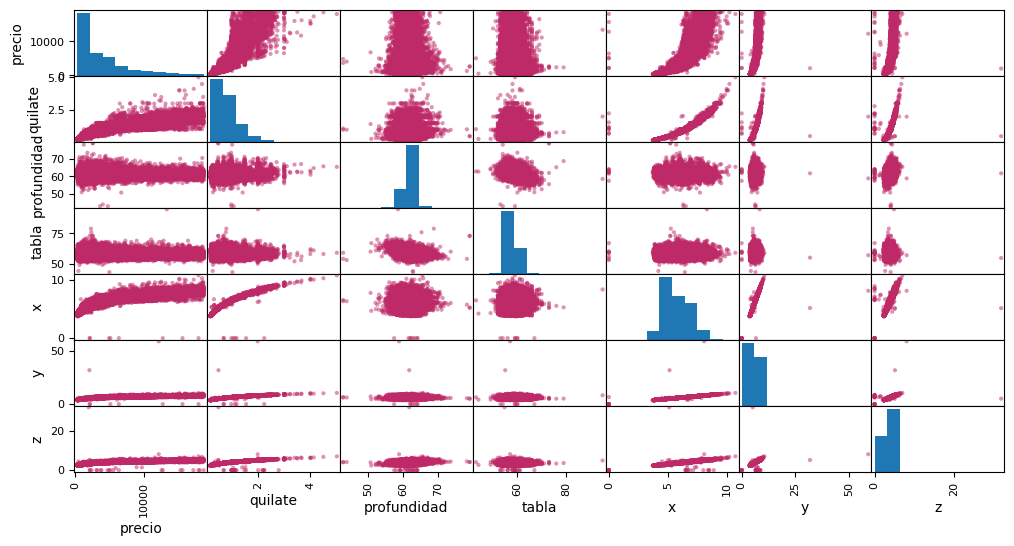

In [ ]:
#Creando una matriz de gráficos de dispersión
#Mostrando relaciones entre los atributos
atributos = ["precio","quilate","profundidad","tabla","x","y","z"]
scatter_matrix(dfd2[atributos], figsize=(12,6), color ="#BE2968")

####**5. Ajuste del modelo**

Con el fin de generar el set de entrenamiento (train) y testeo (test), se crean X_2 e Y_2 para la variable "precio" escogida en el análisis por ser explicativa del valor de los diamantes.

In [ ]:
#Separando las características (X) y la variable objetivo (y)
X_2 = dfd2.drop(columns = ['precio'],axis=1) # se elimina el atributo objetivo de la matriz de atributos
y_2 = dfd2['precio'] # se conserva solo el atributo objetivo

In [ ]:
#Evidenciando la separación en X_2
X_2.head(5)

,quilate,profundidad,tabla,x,y,z,claridad_encoder,color_encoder,corte_encoder
0,0.23,61.5,55.0,3.95,3.98,2.43,3.0,1.0,1.0
1,0.21,59.8,61.0,3.89,3.84,2.31,2.0,1.0,3.0
2,0.23,56.9,65.0,4.05,4.07,2.31,4.0,1.0,0.0
3,0.29,62.4,58.0,4.20,4.23,2.63,5.0,5.0,3.0
4,0.31,63.3,58.0,4.34,4.35,2.75,3.0,6.0,0.0


In [ ]:
#Evidenciando la separación en y_2
y_2.head(5)

0    326.0
1    326.0
2    327.0
3    334.0
4    335.0
Name: precio, dtype: float64

In [ ]:
# División de los datos en entrenamineto (train) y prueba (test)
# ------------------------------------------------------------------------------
# De acuerdo con el artículo registrado en la bibliografía, para una estructura
# de árboles es necesario usar una semilla (random_state).
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2,random_state=1)

In [ ]:
#Vemos que toma registros en forma aleatoria.
X_2_train.head(5)

,quilate,profundidad,tabla,x,y,z,claridad_encoder,color_encoder,corte_encoder
41944,0.35,62.4,58.0,4.47,4.54,2.81,2.0,4.0,3.0
21479,1.52,62.9,59.0,7.31,7.26,4.58,3.0,1.0,3.0
4451,0.90,61.9,56.0,6.18,6.23,3.84,3.0,2.0,1.0
24948,1.70,62.1,57.0,7.61,7.55,4.71,2.0,3.0,3.0
7281,1.00,61.0,62.0,6.41,6.34,3.89,3.0,1.0,3.0


In [ ]:
#Identificando los datos para y_2
y_2_test.head(5)

2714      564.0
14653    5914.0
52760    2562.0
48658     537.0
14812    5964.0
Name: precio, dtype: float64

In [ ]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeRegressor(
            max_depth         = 5,
            random_state      = 1
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_2_train, y_2_train)

DecisionTreeRegressor(max_depth=5, random_state=1)

Profundidad del árbol: 5
Número de nodos terminales: 32


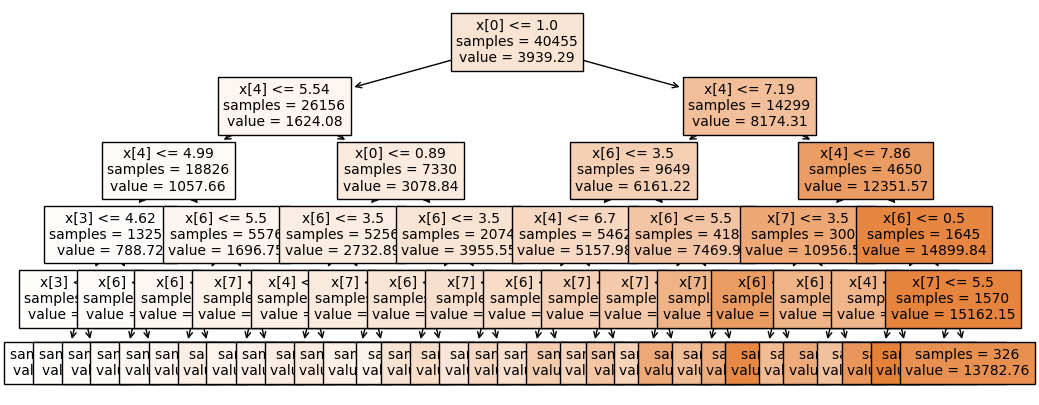

In [ ]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")
#feature_names = labels.tolist(),

plot = plot_tree(
            decision_tree = modelo,

            class_names   = 'precio',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

**Observación**: Se obtiene un primer árbol como resultado del **modelo inicial**, sin poda con 32 nodos terminales y una profundidad de 5.

In [ ]:
#feature_names = list(labels.tolist())
texto_modelo = export_text(
                    decision_tree = modelo,

               )
#print(texto_modelo)

####**6. Predicción y evaluación del modelo inicial**

En este paso se realizará la predicción para el conjunto de prueba (y_2_pred). Luego se procederá a evaluar el rendimiento del modelo de regresión en función de su capacidad para ajustarse a los datos observados y predecir correctamente los valores de la variable objetivo.

In [ ]:
#Definiendo la función para evaluar las métricas de regresión
def regression_results(y_2_true, y_2_pred):

    """
    Con esta función se calculan varias métricas de regresión
    a partir de dos arrays NumPy,
    "y_2_true" y "y_2_pred", que contienen los valores verdaderos y predichos.

    Métricas de regresión:

    explained_variance: la varianza explicada del modelo
    mean_absolute_error: el error absoluto medio del modelo
    mse: el error cuadrático medio del modelo
    mean_squared_log_error: el error cuadrático medio del logaritmo de las predicciones y los valores verdaderos.
    median_absolute_error: la mediana del error absoluto entre las predicciones y los valores verdaderos.
    r2: el coeficiente de determinación R^2 del modelo.
    """

    explained_variance=metrics.explained_variance_score(y_2_true, y_2_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_2_true, y_2_pred)
    mse=metrics.mean_squared_error(y_2_true, y_2_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_2_true, y_2_pred)
    median_absolute_error=metrics.median_absolute_error(y_2_true, y_2_pred)
    r2=metrics.r2_score(y_2_true, y_2_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
#Realizando predicciones en el conjunto de prueba:
y_2_pred = modelo.predict(X_2_test)
print(y_2_pred)

#Evaluando el rendimiento del modelo utilizando el error absoluto medio (MAE):
mean_absolute_error=metrics.mean_absolute_error(y_2_test, y_2_pred)
print('MAE:', round(mean_absolute_error, 2))

[ 740.55600059 5855.27031651 3198.71878515 ... 5855.27031651 3801.43474962
 1142.48864668]
MAE: 580.78


In [ ]:
regression_results(y_2_test, y_2_pred)

explained_variance:  0.9286
mean_squared_log_error:  0.0447
r2:  0.9286
MAE:  580.7779
MSE:  1104300.9191
RMSE:  1050.8572


**Observación**: al analizar la precisión del modelo mediante su MAE, se observa que el valor del MAE = 580.7779, esto con una profundidad de 5.
Se buscará disminuir este error mediante el proceso de poda.

Adicionalmente, se observa que r2 = 0.9286, por lo que se acerca a 1. Esto indica que mejor será el ajuste del modelo de regresión y, por lo tanto, mejor será su capacidad para predecir los valores de la variable objetivo.

####**7. Podado del árbol (pruning)**

Utilizaremos el hiperparámetro "ccp_alpha" para controlar el umbral de complejidad del árbol de decisión. Asignaremos el valor None para "max_depth" para luego intentar identificar la profundidad óptima para aumentar la capacidad predictiva del modelo.

In [ ]:
# Pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
#param_grid = {'max_depth':[i for i in range(1,15)]}
param_grid = {'ccp_alpha':np.linspace(190, 220, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(

        estimator = DecisionTreeRegressor(
                            max_depth         = 4,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 1
                       ),
        param_grid = param_grid,
        cv         = 3,
        refit      = True,
        return_train_score = True
      )

In [ ]:
grid.fit(X_2_train, y_2_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(max_depth=4, random_state=1),
             param_grid={'ccp_alpha': array([190.        , 193.33333333, 196.66666667, 200.        ,
       203.33333333, 206.66666667, 210.        , 213.33333333,
       216.66666667, 220.        ])},
             return_train_score=True)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


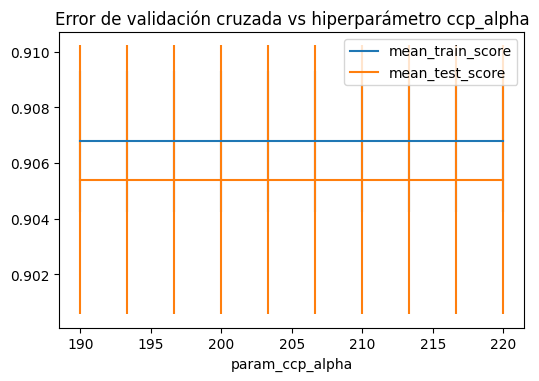

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validación cruzada vs hiperparámetro ccp_alpha");

In [ ]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 190.0}

**Observación**: el valor óptimo de ccp_alpha en 190.0, esto implica que se elegirá el subárbol con la mayor complejidad de costos que sea menor que 190.0

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 4
Número de nodos terminales: 16


**Observación**: para la poda de árbol indicamos 4 al parámetro max_depth, y obtuvimos un árbol con 16 nodos terminales. Es decir, se redujo la cantidad de nodos de 32 a 16, lo que nos pudiese indicar que el árbol no se encuentra sobreajustado.

####**8. Predicción y evaluación del modelo final**

In [ ]:
predicciones_final = modelo_final.predict(X = X_2_test,)

In [ ]:
regression_results(y_2_test, predicciones_final)

explained_variance:  0.9082
mean_squared_log_error:  0.0551
r2:  0.9081
MAE:  668.088
MSE:  1420357.2713
RMSE:  1191.7874


**Observación**: al contrastar la precisión inicial y final del modelo mediante su MAE, se observa que el valor del MAE inicial = 580.7779, disminuyó a MAE = 359.35, esto con una profundidad de 4.
Es decir, se logra disminuir este error mediante el proceso de poda.

Adicionalmente, se observa que r2 inicial = 0.9286, aumentó a r2 = 0.9696, por lo que se acerca aún más a 1. Esto indica que mejor será el ajuste del modelo de regresión y, por lo tanto, mejor será su capacidad para predecir los valores de la variable objetivo.

####**10. Conclusiones: Desafío 2**

El modelo inicial tiene un R-cuadrado de 92.86 % y un error medio absoluto aproximado de 580.78 dólares.

Después del proceso de poda, la nueva predicción indica un  R-cuadrado de 96.96 % y un error absoluto medio aproximado de 359.35 dólares.

Se puede observar que después del proceso de poda hay variaciones en el R2 y MAE:

    - r2, diferencia de aproximadamente 4 puntos porcentuales.

    - MAE, diferencia aproximada de 221.43 dólares.
  
Es decir, mediante el proceso de poda del árbol de regresión, se logró ubicar el r2 muy próximo a 1 y disminuir el error absoluto medio.

En general, es posible realizar predicciones de precios de diamantes para este dataset mediante un árbol de regresión sin que el modelo se sobreajuste, reduciendo el error o margen de precio en 359.35 dólares, es decir, nos podríamos equivocar en estimar el valor final por alrededor de 360 dólares

📖
---

**Bibliografía**

- Introduction to Machine Learning with Python: A Guide for Data Scientists libro

- https://www.tiffany.com.mx/engagement/the-tiffany-guide-to-diamonds/clarity/

- https://www.bluenile.com/mx/education/diamonds/color

- https://www.bntdiamonds.com/es/que-son-las-4-c3

- https://www.analyticslane.com/2022/02/25/calcular-el-numero-optimo-de-bins-para-un-histograma/

- https://interactivechaos.com/es/python/function/sklearnmodelselectiontraintestsplit

- https://elmundodelosdatos.com/tecnicas-para-codificar-variables-categoricas-ordinal-one-hot/

- https://medium.com/mlearning-ai/what-the-heck-is-random-state-24a7a8389f3d